In [1]:
from astropy.time import Time
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
plt.style.use('default')
from scipy.signal import find_peaks, peak_prominences
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import GPy
from sklearn.metrics import mean_squared_error

np.random.seed(42)
#

In [2]:
data_path = '../../Data/'
work_path = '.'

Amount of data samples in plot NuSTAR: 107
Amount of data samples in plot Chandra: 191
Amount of data samples in plot VLT: 39
Amount of data samples in plot Spitzer: 6856
Amount of data samples in plot ALMA: 196
Total amount of data samples: 7389


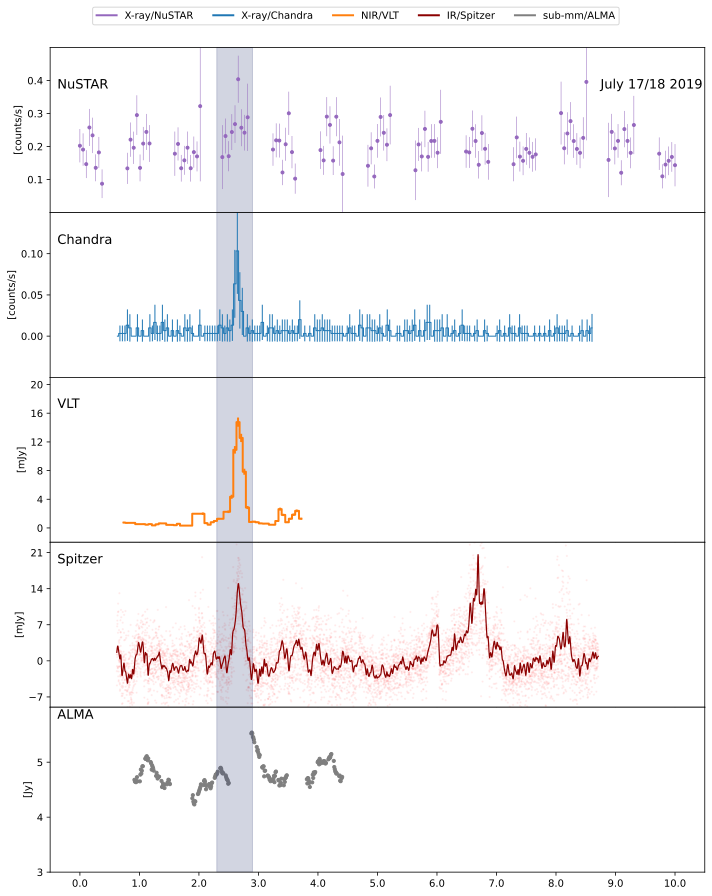

In [53]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)

# Plot 1 - NuSTAR
axs[0].errorbar(scaled_bmjd1, flux1, error1, fmt='o', color='tab:purple', markersize=3, linewidth=0.5)
axs[0].set_ylim(0, 0.5)
axs[0].set_yticks([0.1, 0.2, 0.3, 0.4])
axs[0].set_ylabel('[counts/s]')

# Plot 2 - Chandra
file2 = data_path + '0718chan.dat'
df2 = np.genfromtxt(file2, delimiter=' ')
bmjd2 = df2[:, 0]
scaled_bmjd2 = rescale_bmjd(bmjd2, bmjd1)
flux2 = df2[:, 1]
error2 = df2[:, 2]
axs[1].errorbar(scaled_bmjd2, flux2, error2, linewidth=1, drawstyle='steps-mid', color='tab:blue')
axs[1].set_ylim(-0.05, 0.15)
axs[1].set_yticks([0.0, 0.05, 0.10])
axs[1].set_ylabel('[counts/s]')

# Plot 3 - VLT
file3 = data_path + '0718grav.dat'
df3 = np.genfromtxt(file3)
bmjd3 = df3[:, 0]
scaled_bmjd3 = rescale_bmjd(bmjd3, bmjd1)
flux3 = df3[:, 1]
error3 = df3[:, 2]
axs[2].errorbar(scaled_bmjd3, flux3, error3, linewidth=2, drawstyle='steps-mid', color='tab:orange')
axs[2].set_ylim(-2, 21)
axs[2].set_yticks([0, 4, 8, 12, 16, 20])
axs[2].set_ylabel('[mJy]')

# Plot 4 - Spitzer
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
scaled_bmjd4 = rescale_bmjd(bmjd4, bmjd1)
flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
axs[3].plot(scaled_bmjd4, flux_binned4, linewidth=1.2, color='darkred')
axs[3].scatter(scaled_bmjd4, flux_excess4, color='red', alpha=0.05, s=2)
axs[3].set_ylim(-9, 23)
axs[3].set_yticks([-7, 0, 7, 14, 21])
axs[3].set_ylabel('[mJy]')

# Plot 5 - ALMA
file5 = data_path + '0718alma.dat'
df5 = np.genfromtxt(file5, delimiter=' ')
bmjd5 = df5[:, 2]
scaled_bmjd5 = rescale_bmjd(bmjd5, bmjd1)
flux5 = df5[:, 3]
axs[4].scatter(scaled_bmjd5, flux5, s=10, color='tab:gray')
axs[4].set_ylim(3, 6)
axs[4].set_yticks([3.0, 4.0, 5.0])
axs[4].set_ylabel('[Jy]')

# Adjust subplot spacing
plt.tight_layout()

for ax in axs:
    ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs[2].set_xticks(xticks)
axs[2].set_xticklabels(xtick_labels, rotation=45)
axs[2].set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
    Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
    Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
    Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),
]

# Add annotations
fig.text(0.84, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'NuSTAR', fontsize=13)
fig.text(0.085, 0.76, 'Chandra', fontsize=13)
fig.text(0.085, 0.57, 'VLT', fontsize=13)
fig.text(0.085, 0.39, 'Spitzer', fontsize=13)
fig.text(0.085, 0.21, 'ALMA', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
for ax in axs:
    ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

print('Amount of data samples in plot NuSTAR: %d' % len(scaled_bmjd1))
print('Amount of data samples in plot Chandra: %d' % len(scaled_bmjd2))
print('Amount of data samples in plot VLT: %d' % len(scaled_bmjd3))
print('Amount of data samples in plot Spitzer: %d' % len(scaled_bmjd4))
print('Amount of data samples in plot ALMA: %d' % len(scaled_bmjd5))
print('Total amount of data samples: %d' % (len(scaled_bmjd1) + len(scaled_bmjd2) + len(scaled_bmjd3) + len(scaled_bmjd4) + len(scaled_bmjd5)))

# Show the combined figure
plt.show()

In [54]:
def normalize(Y):
    Y_mean = Y.mean()
    Y_std = Y.std()
    return ((Y - Y_mean) / Y_std).reshape(-1, 1)

In [59]:
# Create a single input array for all datasets
X1 = scaled_bmjd1[:, None]  # NuSTAR
X2 = scaled_bmjd2[:, None]  # Chandra
X3 = scaled_bmjd3[:, None]  # VLT
X4 = scaled_bmjd4[:, None]  # Spitzer
X5 = scaled_bmjd5[:, None]  # ALMA

# Create a single output array for all datasets
Y1 = normalize(flux1)
Y2 = normalize(flux2)
Y3 = normalize(flux3)
Y4 = normalize(flux_binned4)
Y5 = normalize(flux5)

In [62]:
peaks, _ = find_peaks(flux_binned4, height=0) 

# Calculate the prominence of each peak
prominences = peak_prominences(flux_binned4, peaks)[0]

# Find the index of the second most significant peak
sorted_indices = np.argsort(prominences)[::-1]
second_peak_idx = peaks[sorted_indices[1]]

# Determine the start and end of the second most significant peak
threshold = flux_binned4[second_peak_idx] * 0  # Example threshold at 50% peak height

# Find where the signal rises above and falls below the threshold
start_idx = np.where(flux_binned4[:second_peak_idx] < threshold)[0]
end_idx = np.where(flux_binned4[second_peak_idx:] < threshold)[0]

start_idx = start_idx[-1] if len(start_idx) > 0 else 0
end_idx = second_peak_idx + end_idx[0] if len(end_idx) > 0 else len(flux_binned4) - 1

# Print or use the start and end x-values
start_x = scaled_bmjd4[start_idx]
end_x = scaled_bmjd4[end_idx]

print(f"Second most significant peak starts at x = {start_x} and ends at x = {end_x}")


Second most significant peak starts at x = 2.5011323067633198 and ends at x = 2.8539101137429275


In [63]:
peak_indices = np.arange(start_idx, end_idx + 1)
peak_X_test = scaled_bmjd4[peak_indices]
peak_y_test = flux_binned4[peak_indices]
temp_X_train = np.delete(scaled_bmjd4, peak_indices)
temp_y_train = np.delete(flux_binned4, peak_indices)

In [64]:
fraction_to_keep = 0.1  # e.g., keep 10% of the data points
num_points_to_keep = int(fraction_to_keep * len(temp_X_train))
indices = np.random.choice(len(temp_X_train), size=num_points_to_keep, replace=False)

X_train = temp_X_train[indices]
y_train = temp_y_train[indices]
X_test = np.delete(temp_X_train, indices)
y_test = np.delete(temp_y_train, indices)

In [65]:
sort_indices = np.argsort(np.append(X_test, peak_X_test))
X_test = np.append(X_test, peak_X_test)[sort_indices]
y_test = np.append(y_test, peak_y_test)[sort_indices]

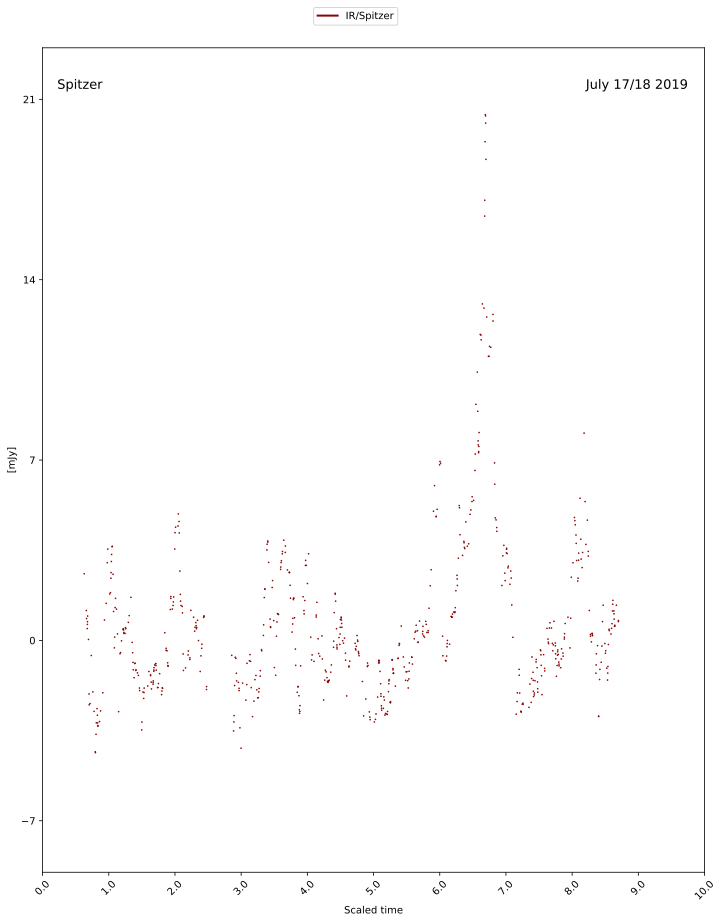

In [66]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(X_train, y_train, s=0.5, color='darkred')
axs.set_ylim(-9, 23)
axs.set_yticks([-7, 0, 7, 14, 21])
axs.set_ylabel('[mJy]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
]

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'Spitzer', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

# GP

In [67]:
model = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=GPy.kern.RBF(1) + GPy.kern.Bias(1))
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0005   1.284464e+03   3.318128e+04 
    02s30  0050   2.229780e+02   3.488869e+03 
    03s20  0070   2.226389e+02   4.609547e-03 
Runtime:     03s20
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.rbf.variance,5.769993249373484,+ve,
sum.rbf.lengthscale,0.015716801409527137,+ve,
sum.bias.variance,0.4032709044492964,+ve,
Gaussian_noise.variance,1.2114507423120463e-07,+ve,


In [68]:
preds = model.predict(X_test.reshape(-1, 1))

print(mean_squared_error(y_test, preds[0].flatten()))

2.654857166293914


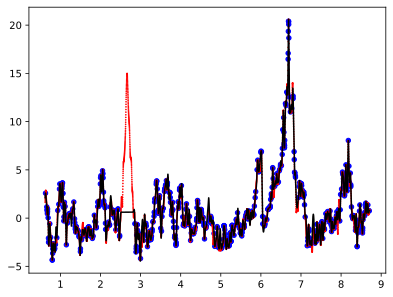

In [69]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()

{'dataplot': [<matplotlib.collections.PathCollection at 0x71f38d121a20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x71f3922227d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x71f392223d60>]}

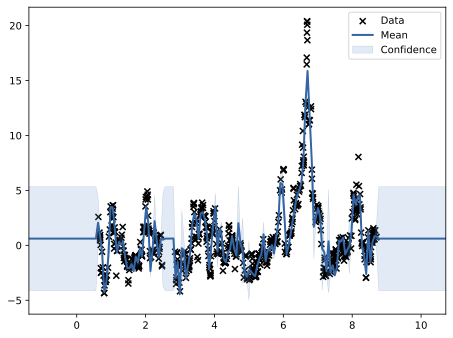

In [70]:
model.plot()

# MOPG

In [71]:
K1 = GPy.kern.Bias(1) # Bias kernel K_bias. Controls the mean function of the GP
K2 = GPy.kern.RBF(1) # RBF kernel K_rbf
K3 = GPy.kern.White(1)

lcm = GPy.util.multioutput.LCM(input_dim = 1, num_outputs = 3, kernels_list = [K1, K2, K3]) # LCM kernel. Adds coregionalization matrix to each kernel in the list: B_1 x K_bias + B_2 x K_rbf

model = GPy.models.GPCoregionalizedRegression(X_list = [X2, X3, X_train.reshape(-1, 1)], Y_list = [Y2, Y3, y_train.reshape(-1, 1)], kernel = lcm) # X2 = Chandra, X3 = VLT, X_train = Spitzer

# model['sum.ICM0.B.W'].constrain_fixed(0) # Constrain and fix the W of the bias kernel to 0. This means the biases will be independent of the other wavelengths
# model['sum.ICM1.B.W'][2].constrain_bounded(10, 20)

display(model) # Allows for the display below

model.optimize()

gp.,value,constraints,priors
sum.ICM0.bias.variance,1.0,+ve,
sum.ICM0.B.W,"(3, 1)",,
sum.ICM0.B.kappa,"(3,)",+ve,
sum.ICM1.rbf.variance,1.0,+ve,
sum.ICM1.rbf.lengthscale,1.0,+ve,
sum.ICM1.B.W,"(3, 1)",,
sum.ICM1.B.kappa,"(3,)",+ve,
sum.ICM2.white.variance,1.0,+ve,
sum.ICM2.B.W,"(3, 1)",,
sum.ICM2.B.kappa,"(3,)",+ve,


In [72]:
display(model.param_array)
display(model)

array([ 1.62080125e-03,  7.28565210e-03,  4.32262099e+00, -1.58469272e+01,
        1.27124543e-05,  1.55897384e-04,  7.18203728e-01,  5.92593626e-01,
        1.57379357e-02,  9.84057477e-01,  8.56488879e-01, -9.63991827e-03,
        6.58174037e-01,  2.79469323e-02,  9.79975462e+00,  8.37979668e-08,
       -9.84500918e-01,  1.46425410e-01, -8.11212864e-01,  4.28957835e-02,
        2.17448102e-01,  8.05080330e-01,  5.52501983e-03,  4.88338000e-03,
        5.06577494e-13])

gp.,value,constraints,priors
sum.ICM0.bias.variance,0.00162080125222951,+ve,
sum.ICM0.B.W,"(3, 1)",,
sum.ICM0.B.kappa,"(3,)",+ve,
sum.ICM1.rbf.variance,0.5925936255259252,+ve,
sum.ICM1.rbf.lengthscale,0.015737935708143937,+ve,
sum.ICM1.B.W,"(3, 1)",,
sum.ICM1.B.kappa,"(3,)",+ve,
sum.ICM2.white.variance,8.37979668078572e-08,+ve,
sum.ICM2.B.W,"(3, 1)",,
sum.ICM2.B.kappa,"(3,)",+ve,


In [73]:
X_test_with_index = np.hstack((X_test.reshape(-1, 1), (2 * np.ones_like(X_test)).reshape(-1,1)))
Y_metadata = {'output_index': X_test_with_index[:, 1:].astype(int)}
preds = model.predict(X_test_with_index, Y_metadata=Y_metadata)

print(mean_squared_error(y_test, preds[0].flatten()))

2.6653139575939537


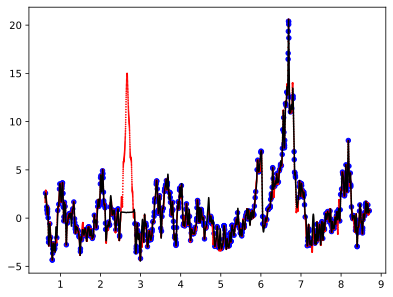

In [74]:
plt.scatter(X_train, y_train, s=20, color='b')
plt.plot(X_test, preds[0].flatten(), color='black')
plt.scatter(X_test, y_test, s=0.5, color='r')

plt.show()

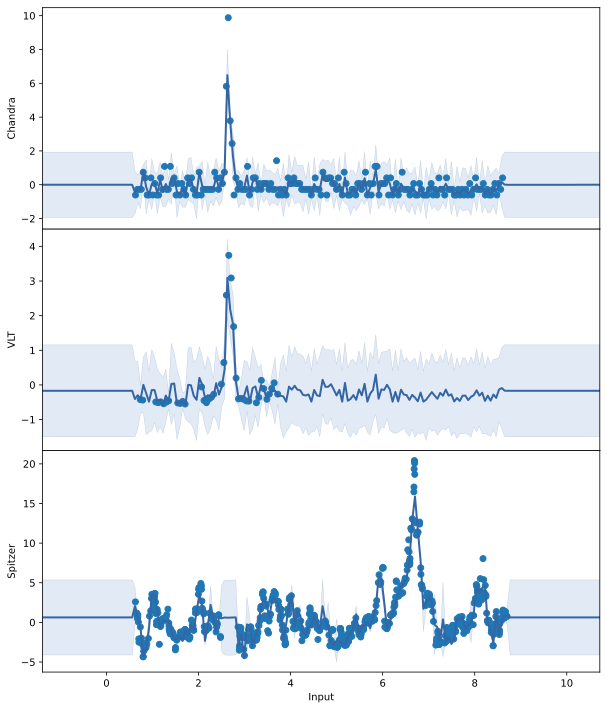

In [75]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)
X_list = [X2, X3, X_train]
Y_list = [Y2, Y3, y_train]
y_labels = ['Chandra', 'VLT', 'Spitzer']

# Loop through each output and plot in its respective subplot
for i in range(3):
    model.plot(plot_data = False, fignum=None, fixed_inputs=[(1, i)], ax=axs[i], legend=False)
    axs[i].scatter(X_list[i], Y_list[i])
    # axs[i].set_title()
    axs[i].set_ylabel(y_labels[i])
    if i == 2:
        axs[i].set_xlabel('Input')